# 時系列分析(季節&トレンド)

## 方針

- レベル・トレンド・周期性の3要因に分けて、モデルを構築し、予測し、評価する。
- データを訓練データ、バリデーションデータ、テストデータの3つに分け、訓練データによって得られたモデルをバリデーションデータによって評価し、最適なモデルを選択する。テストデータは候補モデルの調査を一通り終えた後、最終評価にのみ使用する。
    - 分割の期間は各パーツ毎に適宜指定する。例えばかなり過去に販売されていたパーツなどは、直近のワランティ件数はほぼ0件であり、「2018年以降」などの一律な期間指定は評価に適さないため。
        - (余談)この方法は評価結果がデータの分割期間に依存する。より期間への依存が少ない方法としては、期間をスライドさせながら複数の評価を行い、その平均値や分布から評価する方法もある。しかしこの方法は、学習に計算時間がかかるモデルについては、計算時間の観点で現実的ではない。**粒子フィルタ(Particle Filter, SMC; Sequential Monte Carloとも)**などの比較的計算時間の少ないパラメータ推定方法では、このような評価方法も可能である。
    - 評価指標としては、バリデーションデータの平均二乗誤差(MSE; Mean Squared Error)を用いる。他、補助的に訓練データのBIC(ベイズ情報量基準)を用いることがある。
- スキルトランスファーの目的のため、以下の手法を用いてそれぞれモデリングを行う。**上2つはほぼ同じ結果となるため、実際では1つ採用すれば十分である。**
    - 1. SARIMA
        - 1.1 SARIMAX<font color=red>**(作業中)**</font>

## データ準備

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

PATH_DATA_INTERIM = Path("../data/interim/")

In [2]:
df_warranty_model_part_num_daily = pd.read_feather(PATH_DATA_INTERIM/"df_warranty_model_part_num_daily.feather")

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [3]:
selected_part_TD = ["27610-76G", "37950-58J", "95411-82K", 
                    "09283-350", "33920-77F", "33220-76G", "55311-75F",
                    "55311-72J", "53200-58J", "84702-70K"]

selected_part_S = ["46860-76G", "95200-58J", "37990-72J", "09262-350",
                   "17400-588"]

In [4]:
ts_dict = {}
ts_dict_monthly = {}
for part in selected_part_TD:
    ts_tmp = (df_warranty_model_part_num_daily
              .loc[df_warranty_model_part_num_daily.part_cd == part,
                          ["date", "n"]]
              .groupby("date")["n"]
              .sum())
    ts_tmp.index = pd.to_datetime(ts_tmp.index)
    ts_dict[part] = ts_tmp
    ts_dict_monthly[part] = ts_tmp.resample("MS").sum()

In [5]:
ts_dict_S = {}
ts_dict_monthly_S = {}
for part in selected_part_S:
    ts_tmp = (df_warranty_model_part_num_daily
              .loc[df_warranty_model_part_num_daily.part_cd == part,
                          ["date", "n"]]
              .groupby("date")["n"]
              .sum())
    ts_tmp.index = pd.to_datetime(ts_tmp.index)
    ts_dict_S[part] = ts_tmp
    ts_dict_monthly_S[part] = ts_tmp.resample("MS").sum()

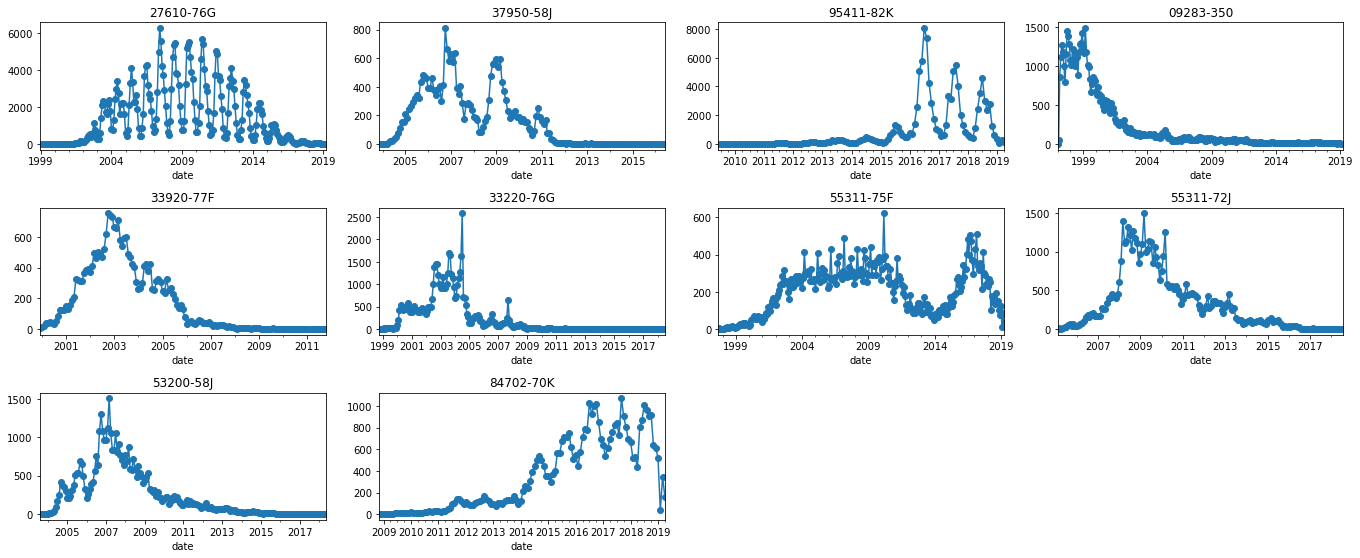

In [6]:
fig = plt.figure(figsize=(19,10))
for i, (part, ts) in enumerate(ts_dict_monthly.items()):
    ax = fig.add_subplot(4,4,i+1)
    ts.plot(style="-o", title=part, ax=ax)

plt.tight_layout()

In [7]:
df_term_devide = pd.DataFrame([{"part":"27610-76G", "valid_start":"2013-01-01", "test_start":"2014-01-01"},
                               {"part":"37950-58J", "valid_start":"2009-01-01", "test_start":"2010-01-01"},
                               {"part":"95411-82K", "valid_start":"2016-01-01", "test_start":"2017-01-01"},
                               {"part":"09283-350", "valid_start":"2000-01-01", "test_start":"2001-01-01"},
                               {"part":"33920-77F", "valid_start":"2003-01-01", "test_start":"2004-01-01"},
                               {"part":"33220-76G", "valid_start":"2003-01-01", "test_start":"2004-01-01"},
                               {"part":"55311-75F", "valid_start":"2016-01-01", "test_start":"2017-01-01"},
                               {"part":"55311-72J", "valid_start":"2011-01-01", "test_start":"2012-01-01"},
                               {"part":"53200-58J", "valid_start":"2008-01-01", "test_start":"2009-01-01"},
                               {"part":"84702-70K", "valid_start":"2016-01-01", "test_start":"2017-01-01"}])
df_term_devide.set_index("part", inplace=True)
df_term_devide["valid_start"] = pd.to_datetime(df_term_devide.valid_start)
df_term_devide["test_start"] = pd.to_datetime(df_term_devide.test_start)

In [8]:
from datetime import datetime, timedelta
datetime(2017,1,1) - timedelta(1)

datetime.datetime(2016, 12, 31, 0, 0)

In [9]:
from datetime import datetime, timedelta

ts_dict_monthly_train, ts_dict_monthly_valid, ts_dict_monthly_test = {},{},{}

for part in selected_part_TD:
    valid_start = df_term_devide.loc[part, "valid_start"]
    test_start = df_term_devide.loc[part, "test_start"]
    train_end = valid_start - timedelta(1)
    valid_end = test_start - timedelta(1)
    
    ts_dict_monthly_train[part] = ts_dict_monthly[part].loc[:train_end]
    ts_dict_monthly_valid[part] = ts_dict_monthly[part].loc[valid_start:valid_end]
    ts_dict_monthly_test[part] = ts_dict_monthly[part].loc[test_start:]

In [10]:
# スズキチームのパーツ(ts_dict_monthly_S)について時系列をプロットしてみましょう


In [11]:
# 各パーツについて、バリデーション期間開始日、テスト期間開始日を指定しましょう


In [12]:
# 各データを訓練、バリデーション、テストに分けましょう


## 分布の確認

### フーリエ変換(6.2.1参照)

### 予測対象の分布

#### 全体,変換なし

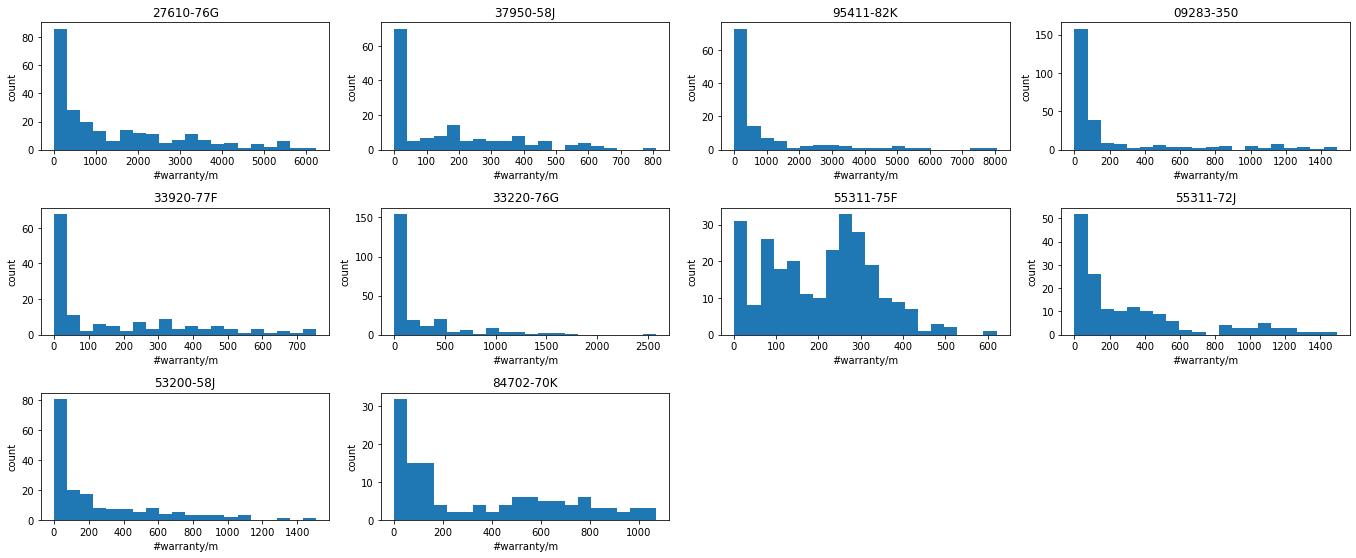

In [13]:
fig = plt.figure(figsize=(19,10))
for i, (part, ts) in enumerate(ts_dict_monthly.items()):
    ax = fig.add_subplot(4,4,i+1)
    ax.hist(ts, bins=20)
    ax.set(ylabel="count", xlabel="#warranty/m", title=part)
plt.tight_layout()

ポアソン分布か。

#### 全体,対数変換

In [57]:
np.e

2.718281828459045

In [58]:
np.e**8

2980.957987041727

**眞田宿題: 調査 形**

In [ ]:
np.()

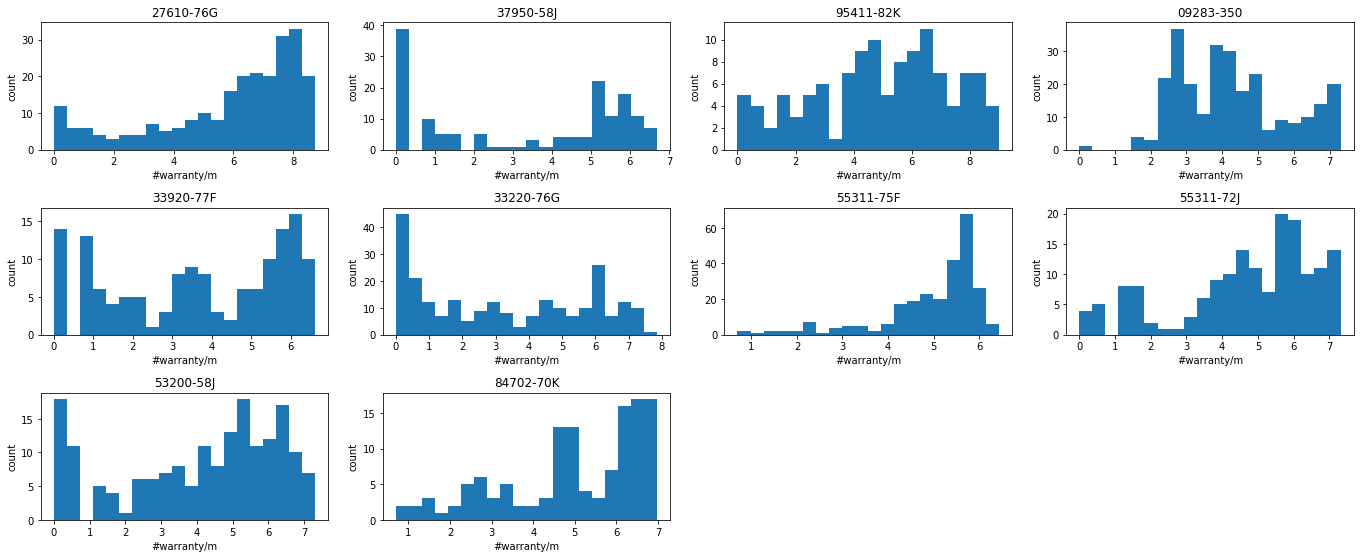

In [14]:
fig = plt.figure(figsize=(19,10))
for i, (part, ts) in enumerate(ts_dict_monthly.items()):
    ax = fig.add_subplot(4,4,i+1)
    ax.hist(np.log1p(ts), bins=20)
    ax.set(ylabel="count", xlabel="#warranty/m", title=part)
plt.tight_layout() 

対数正規分布ではない。

#### 差分, 変換なし

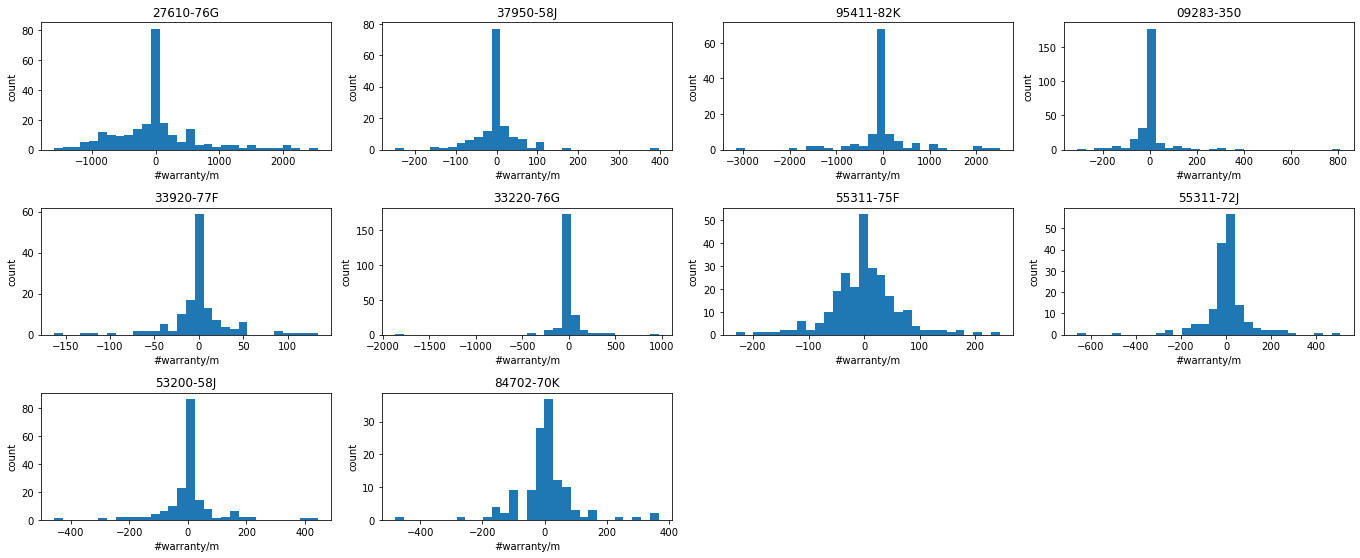

In [15]:
fig = plt.figure(figsize=(19,10))
for i, (part, ts) in enumerate(ts_dict_monthly.items()):
    ax = fig.add_subplot(4,4,i+1)
    ax.hist(ts.diff().dropna(), bins=30)
    ax.set(ylabel="count", xlabel="#warranty/m", title=part)
plt.tight_layout()

#### 差分, 対数変換

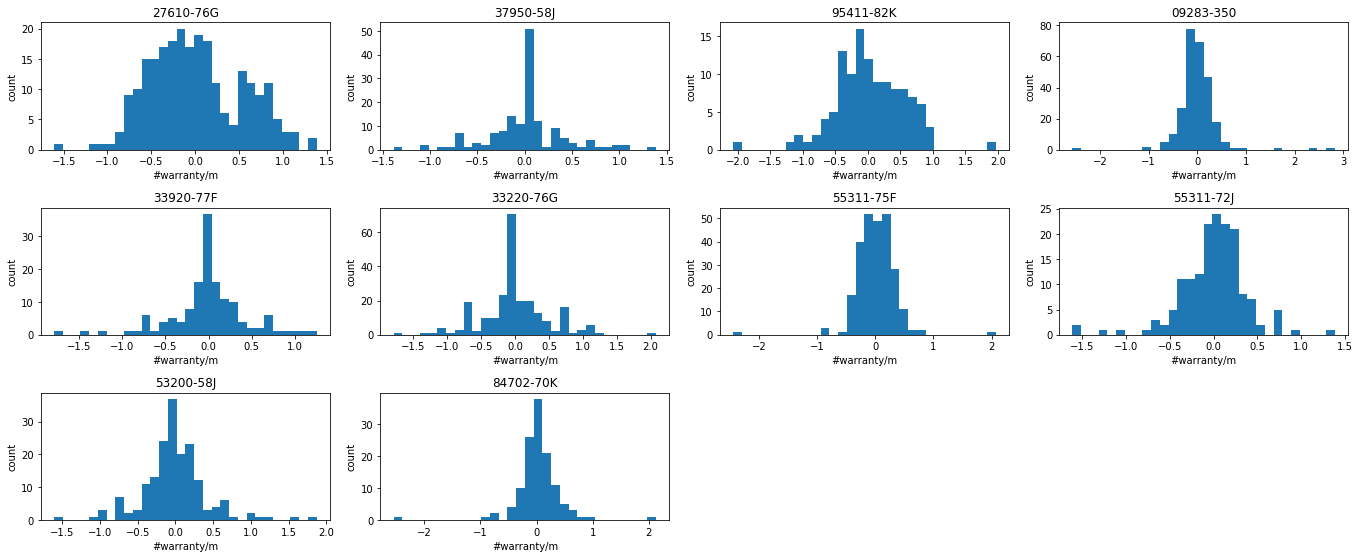

In [16]:
fig = plt.figure(figsize=(19,10))
for i, (part, ts) in enumerate(ts_dict_monthly.items()):
    ax = fig.add_subplot(4,4,i+1)
    ax.hist(np.log1p(ts).diff().dropna(), bins=30)
    ax.set(ylabel="count", xlabel="#warranty/m", title=part)
plt.tight_layout()

## ベースラインモデル

これから作成するモデルの比較対象として、ベースラインとなるモデルを作成・評価する  
今回は**1.ランダムウォークモデル**と、2.稼働台数のx%が故障するモデルの2つをベースラインモデルとする。  
ベースラインとするモデルは、当然各ケースによって異なるが、ランダムウォークモデルはしばしば用いられる。

ランダムウォークモデルとは、以下のようなモデルである。
$$y_{t} = y_{t-1} + \epsilon_{t} \\
\epsilon_{t} \sim N(0, \sigma^2)$$
これは**係数1のAR1モデルと同一**である。
ランダムウォークモデルでは、次の値の期待値は現在の値となる。つまり、(正規分布にしたがうバラツキはもつものの)今とそれほど変わらない、という予測をするモデルである。  
ちなみに、株価や為替のモデルでは、このランダムウォークモデルがベースラインとなることが多い。(そして殆どの場合、ランダムウォークモデルよりも良い予測モデルは作れない...)

### ランダムウォークモデル

In [17]:
ts_monthly_train = ts_dict_monthly_train["27610-76G"]
ts_monthly_valid = ts_dict_monthly_valid["27610-76G"]
ts_monthly = ts_dict_monthly["27610-76G"]

In [18]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

m_baseline = UnobservedComponents(ts_monthly_train, "random walk").fit()

In [19]:
m_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      n   No. Observations:                  169
Model:                    random walk   Log Likelihood               -1350.511
Date:                Tue, 23 Jul 2019   AIC                           2703.021
Time:                        07:39:36   BIC                           2706.145
Sample:                    12-01-1998   HQIC                          2704.289
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level  5.642e+05   4.98e+04     11.324      0.000    4.67e+05    6.62e+05
===================================================================================
Ljung-Box (Q):                     1213.67   Jarque-Bera (JB):                26.31
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              23.03   Skew:                             0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

BIC:2706.15


/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


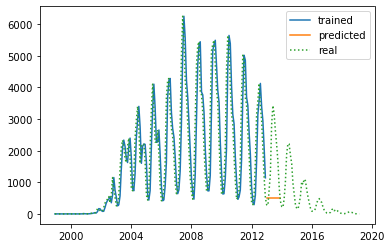

In [20]:
print(f"BIC:{m_baseline.bic:.2f}")
pred = m_baseline.predict()
forc = m_baseline.forecast(12)
ax = plt.subplot(1,1,1)
ax.plot(pred.index, pred.values, label="trained")
ax.plot(forc.index, forc.values, label="predicted")
ax.plot(ts_monthly.index, ts_monthly.values, ":", label="real")
ax.legend()

RMSE: 1592.27


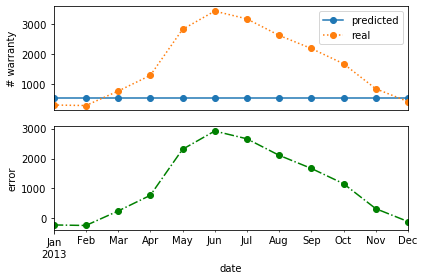

In [21]:
pred = m_baseline.forecast(12)
ax = plt.subplot(2,1,1)
pred.plot(ax=ax, style="o-", label="predicted")
ts_monthly_valid.plot(ax=ax, style="o:", label="real")
ax.set_ylabel("# warranty")
ax.legend()

ax.get_xaxis().set_visible(False)
ax = plt.subplot(2,1,2)
err = ts_monthly_valid - pred
err.plot(ax=ax, style="go-.", label="err")
ax.set_ylabel("error")
plt.tight_layout()
print(f"RMSE: {np.sqrt((err**2).mean()):.2f}")

月次の平均二乗誤差平方根はこのケースでは約1600件。

### 全パーツ

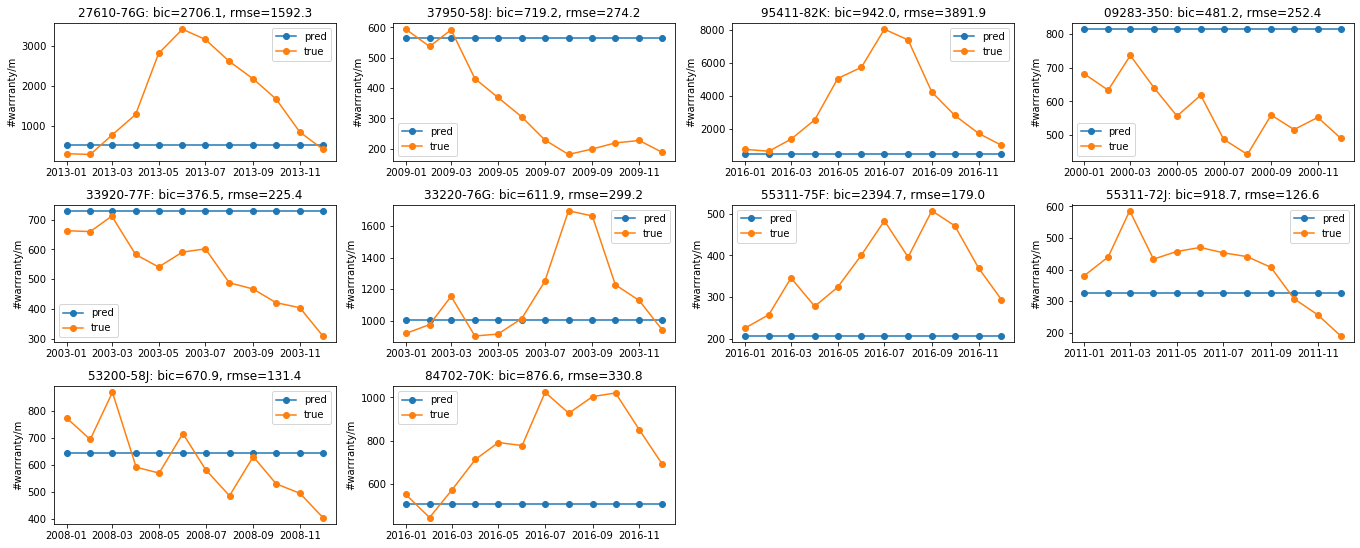

In [22]:
rmse_dict = {}
bic_dict = {}

fig = plt.figure(figsize=(19,10))
for i, part in enumerate(ts_dict_monthly_train.keys()):
    m = UnobservedComponents(ts_dict_monthly_train[part], "random walk").fit()
    pred = m.forecast(12)
    err = ts_dict_monthly_valid[part] - pred
    rmse_dict[part] = np.sqrt((err**2).mean())
    bic_dict[part] = m.bic
    ax = fig.add_subplot(4, 4, i+1)
    ax.plot(pred, "o-", label="pred")
    ax.plot(ts_dict_monthly_valid[part], "o-", label="true")
    ax.legend()
    ax.set(ylabel="#warrranty/m", 
            title=f"{part}: bic={bic_dict[part]:.1f}, rmse={rmse_dict[part]:.1f}")
    
plt.tight_layout()

In [23]:
ts_dict_monthly["27610-76G"].to_csv("../data/interim/monthly_warranty_27610-76G.csv")

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


### 生産台数のX%モデル

→ 次回の生存分析を行う際に計算

## SARIMA

### SARIMAの概要

**SARIMA**はARIMAモデルを、季節変動要因が説明できるように改良したモデルである。ARIMAモデルと同様、非定常な過程についても(差分が定常であれば)使用できる。これと後述の**SARIMAX**を使用すれば、複雑なモデリングを除き、大概の時系列に適用できる。  
(複雑なモデリングについては、状態空間モデルを使用しなくてはならない)

SARIMAの考え方は、周期に対しても(ARIMAのように)差分を取って、ARMAで対応しようというアイデアである。  
例えば、月次のデータがあるとして、季節性を考慮したいとする。その場合、まず12で差分を取る(前年差を計算することになる)。
$$s_{t} = y_{t} - y_{t-12}$$
この前年差を、ARMAモデルで予測する。例えばARMA(1,1)モデルであれば
$$s_{t} = p_{0} + p_{1}s_{t-1} + q_{1}\epsilon_{t-1} + \epsilon_{t}$$
12月の前年差の期待値は、11月の前年差に$p_{1}$を掛けたものに、何かしら定数$p_{0}$を加えて(0とすることもある)、前月の予測結果との誤差に$q_{1}$を掛けたものを加えた値である、というようなモデルである。

また、非定常な時系列だと(月次売上推移など)、周期差分(前年差など)も非定常になることが多い。この場合、周期差分の差分(前年差の月次変化)を取ってから、ARMAにかける。例えば、周期12の差分を取った後に、更に1階差分を取る場合は
$$z_{t} = s_{t} - s_{t-1} = (y_{t} - y_{t-12}) - (y_{t-1} - y_{t-13}) = (y_{t} - y_{t-1}) - (y_{t-12} - y_{t-13}) = d_{t} - d_{t-12}$$

つまり、1階差を取ったあとに、周期12で差分を取る場合と等しい。  
この$sd_{t}$に対して、ARMAで予測を行っていく。例えばARMA(1,1)モデルであれば

$$z_{t} = a_{0} + a_{1}z_{t-1}+ b_{1}\epsilon_{t-1} + \epsilon_{t} = a_{0} + a_{1}\left\{(y_{t} - y_{t-12}) - (y_{t-1} - y_{t-13})\right\} + b_{1}\epsilon_{t-1} + \epsilon_{t}$$

SARIMAについては、AR1,2,3...やMA1,2,3...の他、周期でラグを取ることもある。例えば、通常のラグでAR1まで、周期ラグでAR2, MA1までモデリングする場合は、以下。

$$z_{t} = a_{0} + a_{1}z_{t-1} + a_{12}z_{t-12} + a_{13}z_{t-13} + a_{24}z_{t-24} + a_{25}z_{t-25} + b_{12}\epsilon_{t-12} + \epsilon_{t}$$

前年比の前月差$z_{t}$は、前月の値$z_{t-1}$の他、前年の値$z_{t-12}$や、前年の予測結果に対する誤差(上振れ/下振れ)$\epsilon_{t-12}$などにも関係がある、というアイデアである。

一般形は以下の形となる

$$z_{t} = a_{0} + \left(a_{1}z_{t-1} + ... + a_{p}z_{t-p} \right) \\
 + \left( a_{s\cdot1}z_{t-s\cdot1} + a_{s\cdot1+1}z_{t-s\cdot1-1} + ... + a_{s\cdot1+p}z_{t-s\cdot1-p} \right) \\
 + ... + \\
 + \left( a_{s\cdot p_{s}}z_{t-s\cdot p_{s}} + a_{s\cdot p_{s}+1}z_{t-s\cdot p_{s}-1} + ... + a_{s\cdot p_{s}+p}z_{t-s\cdot p_{s}-p} \right) \\
 + \left(b_{1}\epsilon_{t-1} + ... + b_{q}\epsilon_{t-q} \right) \\
 + \left( b_{s\cdot1}\epsilon_{t-s\cdot1} + b_{s\cdot1+1}\epsilon_{t-s\cdot1-1} + ... + b_{s\cdot1+q}\epsilon_{t-s\cdot1-q} \right) \\
 + ... + \\
 + \left( b_{s\cdot q_{s}}\epsilon_{t-s\cdot q_{s}} + b_{s\cdot q{s}+1}\epsilon_{t-s\cdot q_{s}-1} + ... + b_{s\cdot q_{s}+q}\epsilon_{t-s\cdot q_{s}-q} \right) \\ 
 + \epsilon_{t}$$

### 実装: 単一パーツ

- ライブラリはstatsmodelsを使用する
- statsmodelsは最尤推定により、パラメータを推定している。
    - これはイメージとしては、学習に使用するデータが得られる確率が最も大きくなるようなパラメータを求める方法である。
    - 例えば、コイン投げの結果として、表が100回、裏が100回出たとする。このコインの表の出る確率をパラメータ$\theta$とする。このようなデータが得られる確率は、$\theta$が0.5のときに最大となる。(例えばコインが表が出やすくなっていて、$\theta=0.7$であった場合は、表100回、裏100回というデータはむしろ稀である)この場合に、「$\theta=0.5$である」と推定する方法が最尤推定である。

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

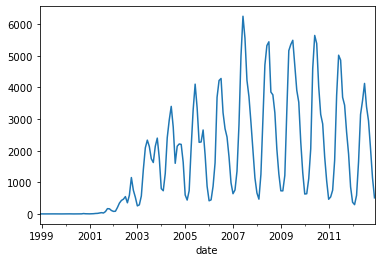

In [25]:
ts_monthly_train.plot()

#### そのままモデリング

In [26]:
from tqdm import tqdm_notebook

In [27]:
%%time

ar_param = [0,1,2,3,4]
ma_param = [0,1,2,3,4]
s_ar_param = [0,1,2]
s_ma_param = [0,1,2]

bic_list = {}

for p in tqdm_notebook(ar_param):
    for q in ma_param:
        for s_p in s_ar_param:
            for s_q in s_ma_param:
                try:
                    m = SARIMAX(ts_monthly_train, order=(p, 1, q), 
                               seasonal_order=(s_p, 1, s_q, 12)).fit()
                    bic_list[(p, q, s_p, s_q)] = m.bic
                except KeyboardInterrupt:
                    raise
                except:
                    pass

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/base/model.py


CPU times: user 12min 52s, sys: 4.65 s, total: 12min 56s
Wall time: 3min 32s


/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [28]:
sorted(bic_list.items(), key=lambda x: x[1])[:5]

[((1, 1, 0, 0), 2287.1391411474583),
 ((1, 1, 0, 1), 2287.9908569398062),
 ((1, 1, 2, 0), 2288.8566021493575),
 ((1, 1, 1, 0), 2289.3386955784104),
 ((0, 0, 2, 0), 2290.0329300488183)]

In [29]:
m_sarima = SARIMAX(ts_monthly_train, order=(1,1,1), seasonal_order=(0,1,0,12)).fit()

上記のモデルは、前年差の月次変化に対して、AR1,MA1でモデリングしたもの。

In [30]:
m_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  n   No. Observations:                  169
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 12)   Log Likelihood               -1135.995
Date:                            Tue, 23 Jul 2019   AIC                           2277.990
Time:                                    07:43:13   BIC                           2287.139
Sample:                                12-01-1998   HQIC                          2281.706
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7238      0.073      9.881      0.000       0.580       0.867
ma.L1         -0.9500      0.038    -24.715      0.000      -1.025      -0.875
sigma2      1.232e+05   1.21e+04     10.193      0.000    9.95e+04    1.47e+05
===================================================================================
Ljung-Box (Q):                      105.94   Jarque-Bera (JB):                 5.15
Prob(Q):                              0.00   Prob(JB):                         0.08
Heteroskedasticity (H):               2.20   Skew:                            -0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# BICは以下のようにしても計算できる。
- 2 * m_sarima.llf + (m_sarima.df_model) * np.log(m_sarima.nobs_effective)

2287.1391411474583

BIC:2287.14


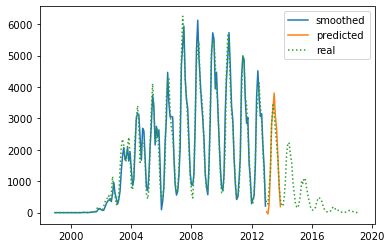

In [32]:
print(f"BIC:{m_sarima.bic:.2f}")
pred = m_sarima.predict()
ax = plt.subplot(1,1,1)
ax.plot(pred.index, pred.values, label="smoothed")
forc = m_sarima.forecast(12)
ax.plot(forc.index, forc.values, label="predicted")
ax.plot(ts_monthly.index, ts_monthly.values, ":", label="real")
ax.legend();

ベースラインモデルのBIC2700前後に比べて、2300前後と改善している。バリデーション期間も比較的良く予測できている。

In [33]:
m_sarima.forecast(steps=12)

2013-01-01      28.857926
2013-02-01     -40.454412
2013-03-01     257.662386
2013-04-01    1323.642173
2013-05-01    2819.798979
2013-06-01    3259.360101
2013-07-01    3804.490060
2013-08-01    3066.307938
2013-09-01    2620.899928
2013-10-01    1754.328417
2013-11-01     821.638563
2013-12-01     188.863050
Freq: MS, dtype: float64

マイナスの値を含んでしまっている。

RMSE: 328.50


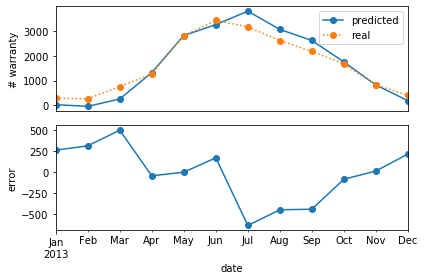

In [34]:
pred = m_sarima.forecast(12)
ax = plt.subplot(2,1,1)
pred.plot(ax=ax, style="o-", label="predicted")
ts_monthly_valid.plot(ax=ax, style="o:", label="real")
ax.set_ylabel("# warranty")
ax.legend()

ax.get_xaxis().set_visible(False)
ax = plt.subplot(2,1,2)
err = ts_monthly_valid - pred
err.plot(ax=ax, style="o-", label="err")
ax.set_ylabel("error")
plt.tight_layout()
print(f"RMSE: {np.sqrt((err**2).mean()):.2f}")

月次の平均二乗誤差平方根はこのケースでは330件。

In [35]:
m_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  n   No. Observations:                  169
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 12)   Log Likelihood               -1135.995
Date:                            Tue, 23 Jul 2019   AIC                           2277.990
Time:                                    07:43:14   BIC                           2287.139
Sample:                                12-01-1998   HQIC                          2281.706
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7238      0.073      9.881      0.000       0.580       0.867
ma.L1         -0.9500      0.038    -24.715      0.000      -1.025      -0.875
sigma2      1.232e+05   1.21e+04     10.193      0.000    9.95e+04    1.47e+05
===================================================================================
Ljung-Box (Q):                      105.94   Jarque-Bera (JB):                 5.15
Prob(Q):                              0.00   Prob(JB):                         0.08
Heteroskedasticity (H):               2.20   Skew:                            -0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

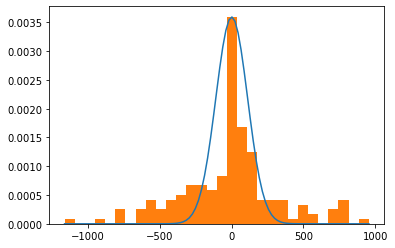

In [36]:
# 実際の誤差の分布と、モデルの仮定する誤差の分布をプロット
from scipy.stats import norm

x_min = m_sarima.resid.min()
x_max = m_sarima.resid.max()
x = np.linspace(x_min, x_max, 101)
plt.plot(x, norm.pdf(x, loc=0, scale=np.sqrt(1.232e+04)), label="predicted error distribution")
plt.hist(m_sarima.resid, bins=30, density=True, label="real error distribution");

正規分布よりもかなり裾野が広い。2008年など、件数の振れ幅が大きくなったときに生じた外れ値だと思われる。

#### 尤度とは？

手元にデータがあるとする。そのデータがある分布から生成されていると仮定したときに、そのデータが得られる確率を尤度と呼ぶ。  
例えば、ある製品の重さが、平均100kg, 標準偏差1kgの正規分布に従っていると仮定する。  
手元に1つ、完成品があり、100.5kgだったとする。このときの尤度は、

In [37]:
norm.pdf(100.5, loc=100, scale=1)

0.3520653267642995

0.35である。

手元に3つ完成品があり、100.5kg, 101.0kg, 99.0kgだったとする。このときの尤度は、  
(100.5kgが出てくる確率)×(101.0kgが出てくる確率)×(99.0kgが出てくる確率)なので、

In [38]:
norm.pdf(100.5, loc=100, scale=1) * norm.pdf(101.0, loc=100, scale=1) * norm.pdf(99, loc=100, scale=1)

0.020613365567604115

0.02である。

データが増えてくると、尤度はとても小さな値の掛け算になりがちである。対数を取ることで、小さな値も精度を保ちながら計算することができる。  
尤度の対数をとった値を**対数尤度**と呼ぶ。

In [39]:
# 上記の例で対数尤度を計算
np.log(norm.pdf(100.5, loc=100, scale=1)) + np.log(norm.pdf(101.0, loc=100, scale=1)) \
    + np.log(norm.pdf(99, loc=100, scale=1))

-3.881815599614018

対数尤度は-3.88

モデルも、一種の確率分布と捉えることができる。  
例えば、モデルの予測値を平均値とする正規分布にしたがって、データが得られていると考えることができる。  
その際、尤度(または対数尤度)は、モデルの"あてはまりの良さ"の指標となる。

例) 以下の身長と体重のデータに対して、(体重) = a(身長^2) + b　+ (誤差) という式でモデリングする。  
モデル1: (体重) = 22.1(身長^2) + 1.2 + (誤差): (誤差は平均0, 標準偏差3.5の正規分布)  
モデル2: (体重) = 19.2(身長^2) - 0.6 + (誤差): (誤差は平均0, 標準偏差2.1の正規分布)  
どちらがあてはまりの良さが良いだろうか？

In [41]:
height = np.array([1.75075563, 1.65653662, 1.77774471, 1.80476451, 1.78612439,
       1.79002119, 1.80489599, 1.6906248 , 1.77291196, 1.77404213,
       1.71955885, 1.70772715, 1.66275771, 1.65073203, 1.70306895,
       1.75948952, 1.71331339, 1.77928317, 1.67501561, 1.65277592,
       1.7307794 , 1.75981476, 1.72569758, 1.63984917, 1.78975793,
       1.76367861, 1.68290945, 1.7052317 , 1.76811622, 1.76325565,
       1.73396813, 1.67555973, 1.65361671, 1.70547883, 1.70948409,
       1.68835057, 1.74065536, 1.75226287, 1.7894315 , 1.75482753,
       1.62578157, 1.76252024, 1.77430214, 1.76588141, 1.72619487,
       1.69483016, 1.77628444, 1.62902441, 1.65154359, 1.77041702,
       1.70160765, 1.73991435, 1.85413177, 1.70601336, 1.71773521,
       1.79360858, 1.91898088, 1.66482127, 1.76144275, 1.75206431,
       1.72278118, 1.66768657, 1.60869243, 1.73249278, 1.69629222,
       1.7203991 , 1.78048852, 1.74882608, 1.77352721, 1.71126809,
       1.7472907 , 1.77264736, 1.68633561, 1.89083358, 1.69846025,
       1.78054801, 1.69860591, 1.76345881, 1.61920179, 1.71454258,
       1.64829334, 1.73466541, 1.71204162, 1.77536078, 1.6188861 ,
       1.71200044, 1.75426074, 1.67994401, 1.69746029, 1.72268901,
       1.62824657, 1.79572171, 1.71882124, 1.70675696, 1.80326494,
       1.79180562, 1.69302757, 1.66795612, 1.70538712, 1.69574936])

weight = np.array([66.11858001, 59.78604719, 62.53046428, 61.00798168, 62.79533074,
       59.62939697, 63.45042442, 62.05145317, 54.72256799, 64.76821155,
       53.93944246, 52.6707546 , 48.18190492, 49.51360018, 53.53403043,
       66.50941263, 62.26464891, 64.41713615, 49.47900091, 62.04076835,
       71.52340827, 60.27826972, 52.69155362, 50.77184332, 66.72565607,
       69.14531045, 56.19597119, 51.97356903, 59.32604209, 59.83492791,
       56.18148657, 49.89917078, 52.64227593, 59.52233181, 47.49184281,
       63.43418546, 66.570281  , 63.96824649, 61.32077687, 59.82847522,
       58.67422903, 57.54172504, 59.97253055, 64.45326256, 56.29848495,
       60.80560926, 63.87643958, 37.458976  , 40.85919484, 59.74899653,
       63.31493188, 61.57818706, 68.99892863, 54.25582331, 66.63286719,
       61.55061276, 79.35760943, 47.26081837, 61.979817  , 63.84319791,
       52.01892653, 53.46378641, 47.23690674, 50.5137554 , 59.20419158,
       64.68830015, 63.83181149, 55.70685344, 66.90863702, 52.90653863,
       57.0812481 , 59.73528551, 57.83880322, 73.0000938 , 55.50162429,
       70.652231  , 64.10897667, 59.42002503, 57.36307236, 54.03334027,
       54.66206582, 63.87493156, 55.20642188, 63.51161811, 59.55888716,
       55.26558681, 69.37013318, 56.88353729, 51.13535979, 63.12259945,
       55.79634281, 59.21870282, 64.54420618, 59.6580128 , 58.23708011,
       60.60500738, 50.2061973 , 44.05627515, 65.83398002, 53.21892499])

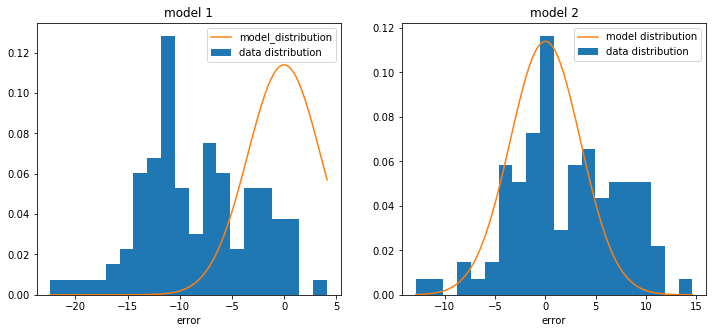

In [42]:
fig = plt.figure(figsize=(12,5))

# モデル1
ax = fig.add_subplot(1,2,1)
weight_pred_1 = 22.1 * height**2 + 1.2
pred_error_1 = weight - weight_pred_1

ax.hist(pred_error_1, bins=20, density=True, label="data distribution")
x = np.linspace(pred_error_1.min(), pred_error_1.max(), 100)
ax.plot(x, norm.pdf(x, loc=0, scale=3.5), label="model_distribution")
ax.set(title = "model 1", xlabel = "error")
ax.legend()

# モデル2
ax = fig.add_subplot(1,2,2)
weight_pred_2 = 19.2 * height**2 - 0.6
pred_error_2 = weight - weight_pred_2
ax.hist(pred_error_2, bins=20, density=True, label="data distribution")
x = np.linspace(pred_error_2.min(), pred_error_2.max(), 100, )
ax.plot(x, norm.pdf(x, loc=0, scale=3.5), label="model distribution")
ax.set(title = "model 2", xlabel = "error")
ax.legend()

BICの計算式は以下の通り。ただし、$L$はデータのモデルに対する尤度、$k$はモデルのパラメータ数、$n$はデータのレコード数である。  
式の意味合いとしては、対数尤度(モデルのあてはまりの良さ)をベースとしているのだが、パラメータの数$k$の分、ペナルティを課している。

$$BIC = -2 \cdot ln(L) + k \cdot ln(n)$$

BIC及びAICの導出は本スキトラの範疇を超えるため割愛するが、例えば[こちら](https://qiita.com/fred55/items/c2d884843686f9e1f618)や[こちら](https://qiita.com/fred55/items/c3a4ce1ece9434b2f816)を参照。

In [60]:
likelihood = 0.0000000000000006354

In [61]:
likelihood

6.354e-16

In [62]:
np.log(likelihood)

-34.99227695205741

In [63]:
np.log10(likelihood)

-15.196952789508872

#### 対数変換を施してからモデリング

In [43]:
m_sarima_l1p = SARIMAX(np.log1p(ts_monthly_train), order=(1,1,1), seasonal_order=(0,1,0,12)).fit()

In [44]:
m_sarima_l1p.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  n   No. Observations:                  169
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 12)   Log Likelihood                 -67.247
Date:                            Tue, 23 Jul 2019   AIC                            140.493
Time:                                    07:43:59   BIC                            149.643
Sample:                                12-01-1998   HQIC                           144.210
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1746      0.115     -1.520      0.128      -0.400       0.050
ma.L1         -0.2897      0.112     -2.593      0.010      -0.509      -0.071
sigma2         0.1385      0.010     13.882      0.000       0.119       0.158
===================================================================================
Ljung-Box (Q):                       54.95   Jarque-Bera (JB):               137.73
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                             1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

BIC:149.64


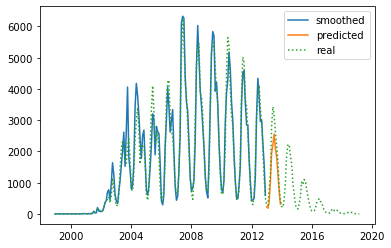

In [45]:
print(f"BIC:{m_sarima_l1p.bic:.2f}")
pred = np.expm1(m_sarima_l1p.predict())
ax = plt.subplot(1,1,1)
ax.plot(pred.index, pred.values, label="smoothed")
forc = np.expm1(m_sarima_l1p.forecast(12))
ax.plot(forc.index, forc.values, label="predicted")
ax.plot(ts_monthly.index, ts_monthly.values, ":", label="real")
ax.legend();

BICは大幅に改善するが、バリデーション期間の予測精度は下がってしまった。

MSE: 532.63


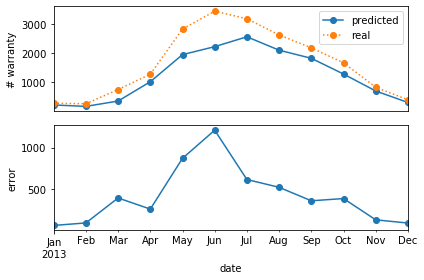

In [46]:
pred = np.expm1(m_sarima_l1p.forecast(12))
ax = plt.subplot(2,1,1)
pred.plot(ax=ax, style="o-", label="predicted")
ts_monthly_valid.plot(ax=ax, style="o:", label="real")
ax.set_ylabel("# warranty")
ax.legend()

ax.get_xaxis().set_visible(False)
ax = plt.subplot(2,1,2)
err = ts_monthly_valid - pred
err.plot(ax=ax, style="o-", label="err")
ax.set_ylabel("error")
plt.tight_layout()
print(f"MSE: {np.sqrt((err**2).mean()):.2f}")

月次の平均二乗誤差平方根はこのケースでは330件。

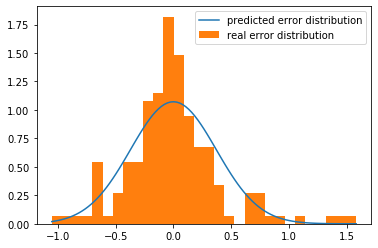

In [47]:
# 誤差の分布をプロット
x_min = m_sarima_l1p.resid.min()
x_max = m_sarima_l1p.resid.max()
x = np.linspace(x_min, x_max, 101)
plt.plot(x, norm.pdf(x, loc=0, scale=np.sqrt(0.1385)), label="predicted error distribution")
plt.hist(m_sarima_l1p.resid, bins=30, density=True, label="real error distribution")
plt.legend();

対数変換を行わないときに比べて、実際の誤差(オレンジ)が、仮定する分布(青線)にフィットしていることがわかる。  
結果、対数尤度が小さくなり、その結果BICも小さくなっている。

ちなみに、対数を取る前に戻すと、以下のようになる。

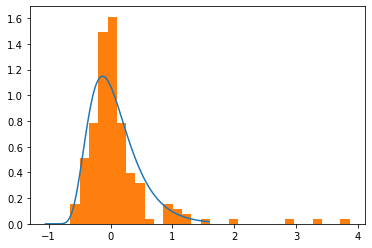

In [48]:
from scipy.stats import lognorm # lognormは、対数正規分布の確率分布を作成するモジュール。

x_min = m_sarima_l1p.resid.min()
x_max = m_sarima_l1p.resid.max()
x = np.linspace(x_min, x_max, 101) # x_minからx_maxまで、計101個の等間隔のリストを作成。

# 後述のexp(x)-1で変換すると xが1ずれるため、それにあわせて確率分布も1つずらす
plt.plot(x, lognorm.pdf((x+1), s=np.sqrt(0.1385)), label="predicted error distribution")

# np.expm1は、exp(x) - 1と同じ。# log1pを元に戻すときに使う。
plt.hist(np.expm1(m_sarima_l1p.resid), bins=30, density=True, label="real error distribution");

### 実装:全パーツ

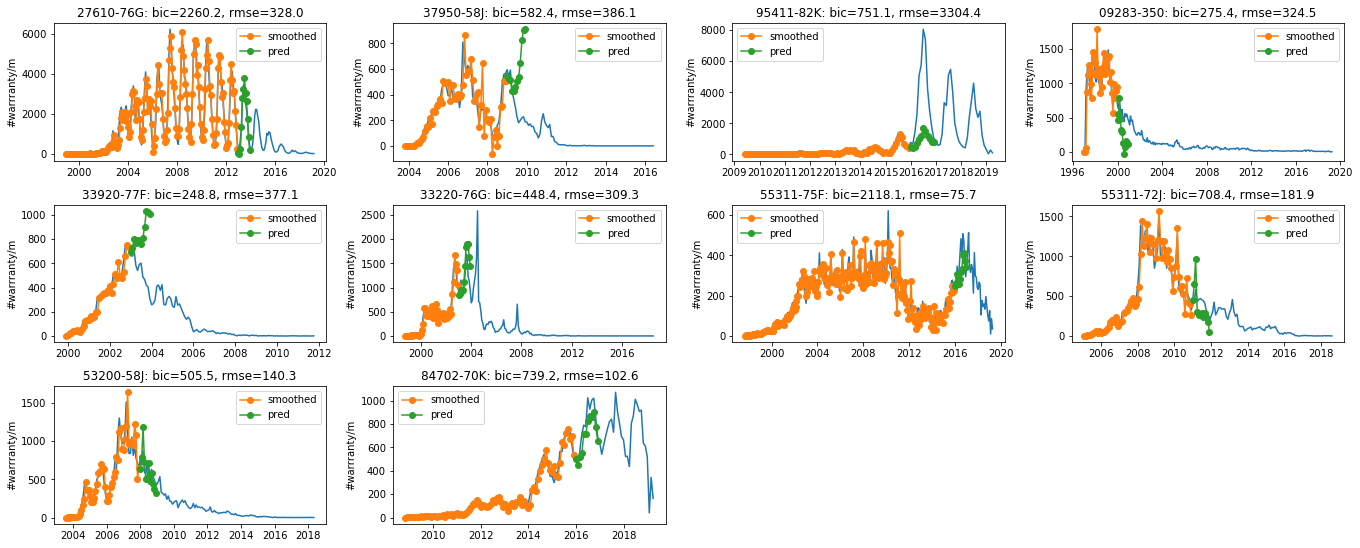

In [49]:
rmse_dict_sarima = {}
bic_dict_sarima = {}

fig = plt.figure(figsize=(19,10))
for i, part in enumerate(ts_dict_monthly_train.keys()):
    # 一旦、全てp,q = 1,1, sp, sq = 0,0でモデリング。
    m = SARIMAX(ts_dict_monthly_train[part], order=(1,1,1), seasonal_order=(0,1,0,12),
               enforce_stationarity=False, enforce_invertibility=False).fit()
    pred = m.forecast(12)
    smoothed = m.predict()
    err = ts_dict_monthly_valid[part] - pred
    rmse_dict_sarima[part] = np.sqrt((err**2).mean())
    bic_dict_sarima[part] = m.bic
    ax = fig.add_subplot(4, 4, i+1)
    ax.plot(ts_dict_monthly[part])
    ax.plot(smoothed, "o-", label="smoothed")
    ax.plot(pred, "o-", label="pred")
#     ax.plot(ts_dict_monthly_valid[part], "o-", label="true")
    ax.legend()
    ax.set(ylabel="#warrranty/m", 
            title=f"{part}: bic={bic_dict_sarima[part]:.1f}, rmse={rmse_dict_sarima[part]:.1f}")
    
plt.tight_layout()

トレンド転換については予測が難しい

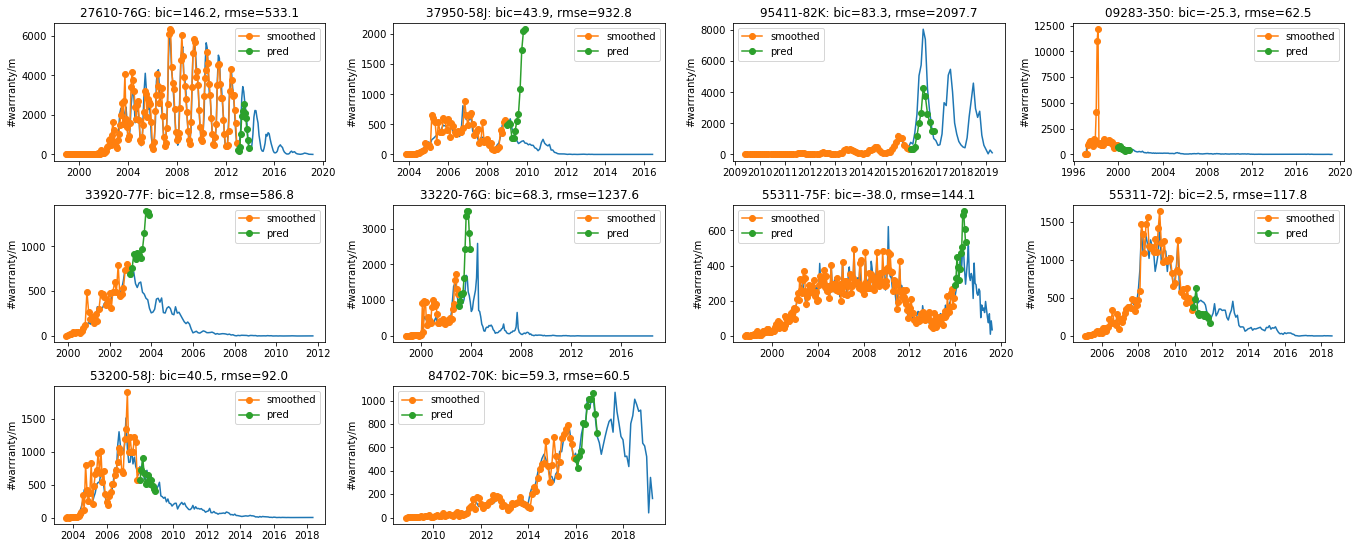

In [50]:
rmse_dict_sarima = {}
bic_dict_sarima = {}

fig = plt.figure(figsize=(19,10))
for i, part in enumerate(ts_dict_monthly_train.keys()):
    # 一旦、全てp,q = 1,1, sp, sq = 0,0でモデリング。
    m = SARIMAX(np.log1p(ts_dict_monthly_train[part]), order=(1,1,1), seasonal_order=(0,1,0,12),
               enforce_stationarity=False, enforce_invertibility=False).fit()
    pred = np.expm1(m.forecast(12))
    smoothed = np.expm1(m.predict())
    err = ts_dict_monthly_valid[part] - pred
    rmse_dict_sarima[part] = np.sqrt((err**2).mean())
    bic_dict_sarima[part] = m.bic
    ax = fig.add_subplot(4, 4, i+1)
    ax.plot(ts_dict_monthly[part])
    ax.plot(smoothed, "o-", label="smoothed")
    ax.plot(pred, "o-", label="pred")
#     ax.plot(ts_dict_monthly_valid[part], "o-", label="true")
    ax.legend()
    ax.set(ylabel="#warrranty/m", 
            title=f"{part}: bic={bic_dict_sarima[part]:.1f}, rmse={rmse_dict_sarima[part]:.1f}")
    
plt.tight_layout()

対数変換は掛けないほうが良さそう

## SARIMAXモデル

### 概要

SARIMAXはSARIMAモデルを、外生変数$x_{1}, x_{2}, ..., x_{k}$の影響も組み込めるように改良したモデルである。  
z_{t}を予測する際の説明に変数に$c_{1}x_{1}, c_{2}x_{2}, ..., c_{k}x_{k}$を加える。

例えば、通常のラグでAR1まで、周期ラグでAR1, MA1までモデリングし、概数変数$x_{1}$と$x_{2}$も組み込んだ場合は、以下。

$$z_{t} = a_{0} + a_{1}z_{t-1} + a_{12}z_{t-12} + a_{13}z_{t-13} + a_{24}z_{t-24} + a_{25}z_{t-25} + b_{12}\epsilon_{t-12} + c_{1}x_{1} + c_{2}x_{2} + \epsilon_{t}$$

$c_{1}x_{1}$と$c_{2}x_{2}$の項が増えている。

一般系は以下の形で書ける

$$z_{t} = a_{0} + \left(a_{1}z_{t-1} + ... + a_{p}z_{t-p} \right) \\
 + \left( a_{s\cdot1}z_{t-s\cdot1} + a_{s\cdot1+1}z_{t-s\cdot1-1} + ... + a_{s\cdot1+p}z_{t-s\cdot1-p} \right) \\
 + ... + \\
 + \left( a_{s\cdot p_{s}}z_{t-s\cdot p_{s}} + a_{s\cdot p_{s}+1}z_{t-s\cdot p_{s}-1} + ... + a_{s\cdot p_{s}+p}z_{t-s\cdot p_{s}-p} \right) \\
 + \left(b_{1}\epsilon_{t-1} + ... + b_{q}\epsilon_{t-q} \right) \\
 + \left( b_{s\cdot1}\epsilon_{t-s\cdot1} + b_{s\cdot1+1}\epsilon_{t-s\cdot1-1} + ... + b_{s\cdot1+q}\epsilon_{t-s\cdot1-q} \right) \\
 + ... + \\
 + \left( b_{s\cdot q_{s}}\epsilon_{t-s\cdot q_{s}} + b_{s\cdot q{s}+1}\epsilon_{t-s\cdot q_{s}-1} + ... + b_{s\cdot q_{s}+q}\epsilon_{t-s\cdot q_{s}-q} \right) \\ 
 + \left(c_{1} x_{1} + ... + c_{k}x_{k} \right) \\
 + \epsilon_{t}$$

### 実装

In [51]:
ftir_part_monthly = pd.read_csv("../data/processed/ftir_monthly.csv")

In [52]:
ftir_part_monthly.head()

,F_MAIN_CAUSE_NO,report_month,n
0,-,2008-06-01,1
1,-,2018-07-01,1
2,-,2018-08-01,1
3,---,2007-05-01,1
4,----,2006-10-01,1


In [53]:
ftir_part_monthly.report_month = pd.to_datetime(ftir_part_monthly.report_month)

In [54]:
ftir_part_monthly_tmp = (ftir_part_monthly
 .loc[ftir_part_monthly.F_MAIN_CAUSE_NO == "27610-76G"]
 .set_index("report_month")["n"]
 .resample("MS").sum())

[Text(0, 0.5, '#FTIR/month'), Text(0.5, 1.0, '27610-76G')]

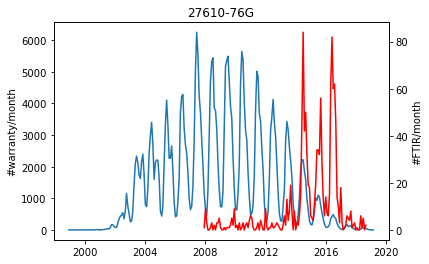

In [55]:
fig, ax = plt.subplots()
ax.plot(ts_monthly, label="#warranty/month")
ax.set(ylabel="#warranty/month")
ax2 = ax.twinx()
ax2.plot(ftir_part_monthly_tmp, "r-", label="#FTIR/month")
ax2.set(ylabel="#FTIR/month", title="27610-76G")

FTIRが発生し始めてから、緩やかに減少している？

他のパーツも見てみる

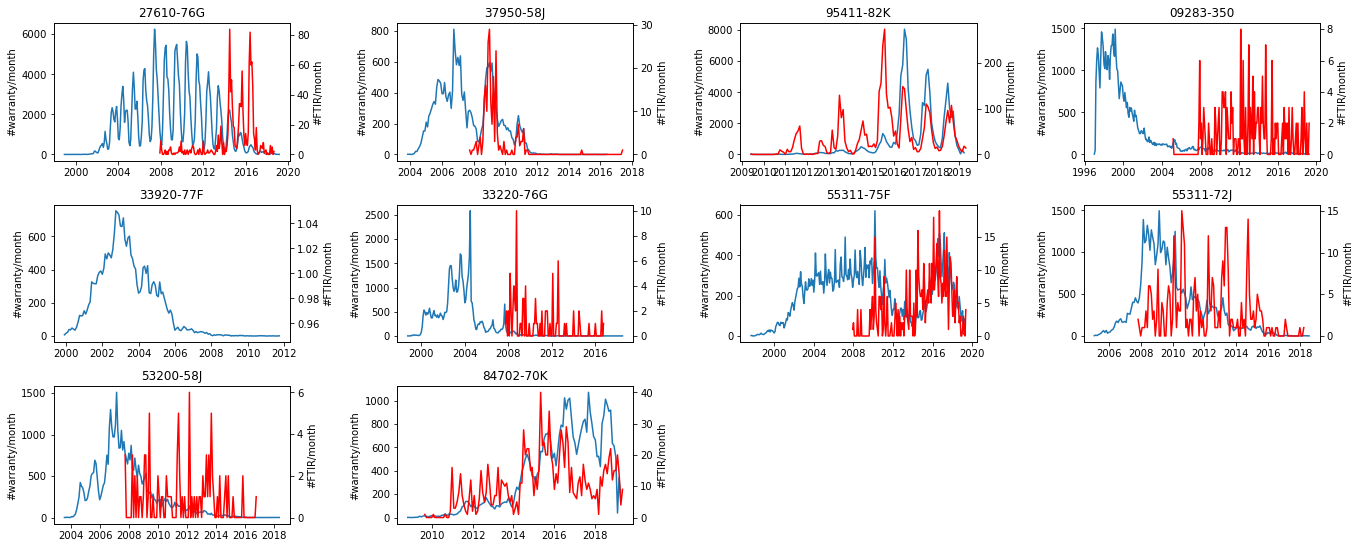

In [56]:
# 15パーツについてチェック
fig = plt.figure(figsize=(19,10))
for i,part in enumerate(ts_dict_monthly.keys()):
    ftir_part_monthly_tmp = (ftir_part_monthly
                             .loc[ftir_part_monthly.F_MAIN_CAUSE_NO == part]
                             .set_index("report_month")["n"]
                             .resample("MS").sum())
    ax = fig.add_subplot(4,4,i+1)
    ax.plot(ts_dict_monthly[part], label="#warranty/month")
    ax.set(ylabel="#warranty/month")
    ax2 = ax.twinx()
    ax2.plot(ftir_part_monthly_tmp, "r-", label="#FTIR/month")
    ax2.set(ylabel="#FTIR/month", title=part)
    
plt.tight_layout()

- FTIRはあまり使えなさそう
    - 先行指標ではない。同時に推移する